In [1]:
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD

In [2]:
from nltk.corpus import stopwords
from nltk.stem.porter import *
import string
import nltk
%matplotlib inline

In [3]:
url = 'http://www.cis.upenn.edu/about-academics/courses.php'

from bs4 import BeautifulSoup as bs
import requests

r = requests.get(url)
soup = bs(r.content, 'html.parser')
course_list = soup.findAll('td')

In [4]:
def tokenize(text):
    text = text.lower() # lower case
    for e in set(string.punctuation+'\n'+'\t'): # remove punctuation and line breaks/tabs
        text = text.replace(e, ' ')	
    for i in range(0,10): # remove double spaces
        text = text.replace('  ', ' ')
    text = text.translate(string.punctuation)  # punctuation
    tokens = nltk.word_tokenize(text)
    text = [w for w in tokens if not w in stopwords.words('english')] # stopwords
    stems = []
    for item in tokens: # stem
        stems.append(PorterStemmer().stem(item))
    return stems

In [5]:
course_names = []
descriptions = []
stemmer = PorterStemmer()
for course in course_list: 
    course_desc = course.getText()
    course_name = ''.join(f.getText() for f in course.findAll('strong'))
    stemmed_course_name = [stemmer.stem(name) for name in course_name]
    stemmed_course_desc = [stemmer.stem(desc) for desc in course_desc]
    course_names.append(''.join(stemmed_course_name))
    descriptions.append(''.join(stemmed_course_desc))

descriptions = filter(None, descriptions)
course_names = filter(None, course_names)    

In [69]:
# Create bag of words vectors
bag_of_words = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, 
                             stop_words = stopwords.words('english'), max_features = 5000) 
wcs = bag_of_words.fit_transform(descriptions)
wcs = wcs.toarray()

# Create tfidf vectors
tfidf = TfidfVectorizer(tokenizer = tokenize, stop_words = 'english')
tfs = tfidf.fit_transform(descriptions)
tfs = tfs.toarray()

# SVD reduction
tfs_reduced = TruncatedSVD(n_components=500, random_state=0).fit_transform(tfs)


In [70]:
from sklearn.metrics.pairwise import linear_kernel
cosine_similarities = linear_kernel(tfs[0:1], tfs).flatten()
related_docs_indices = cosine_similarities.argsort()[:-12:-1]
#related_docs_indices

In [71]:
related_docs_indices

array([  0, 118,  98, 122, 121,  97,  12,  33,  46,  92,  10])

In [72]:
# Perform T-SNE
tsne = TSNE(n_components=2, perplexity=20, verbose=2).fit_transform(tfs)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 129 / 129
[t-SNE] Mean sigma: 0.332059
[t-SNE] Iteration 25: error = 2.5684829, gradient norm = 0.0671343
[t-SNE] Iteration 50: error = 2.2679486, gradient norm = 0.0023113
[t-SNE] Iteration 75: error = 2.1029279, gradient norm = 0.0077247
[t-SNE] Iteration 100: error = 2.0171270, gradient norm = 0.0015161
[t-SNE] Error after 100 iterations with early exaggeration: 2.017127
[t-SNE] Iteration 125: error = 1.9048715, gradient norm = 0.0013963
[t-SNE] Iteration 150: error = 1.8364578, gradient norm = 0.0015683
[t-SNE] Iteration 175: error = 1.8184618, gradient norm = 0.0011384
[t-SNE] Iteration 200: error = 1.8144164, gradient norm = 0.0011354
[t-SNE] Iteration 225: error = 1.8133067, gradient norm = 0.0011420
[t-SNE] Iteration 250: error = 1.8129797, gradient norm = 0.0011439
[t-SNE] Iteration 275: error = 1.8128862, gradient norm = 0.0011445
[t-SNE] Ite

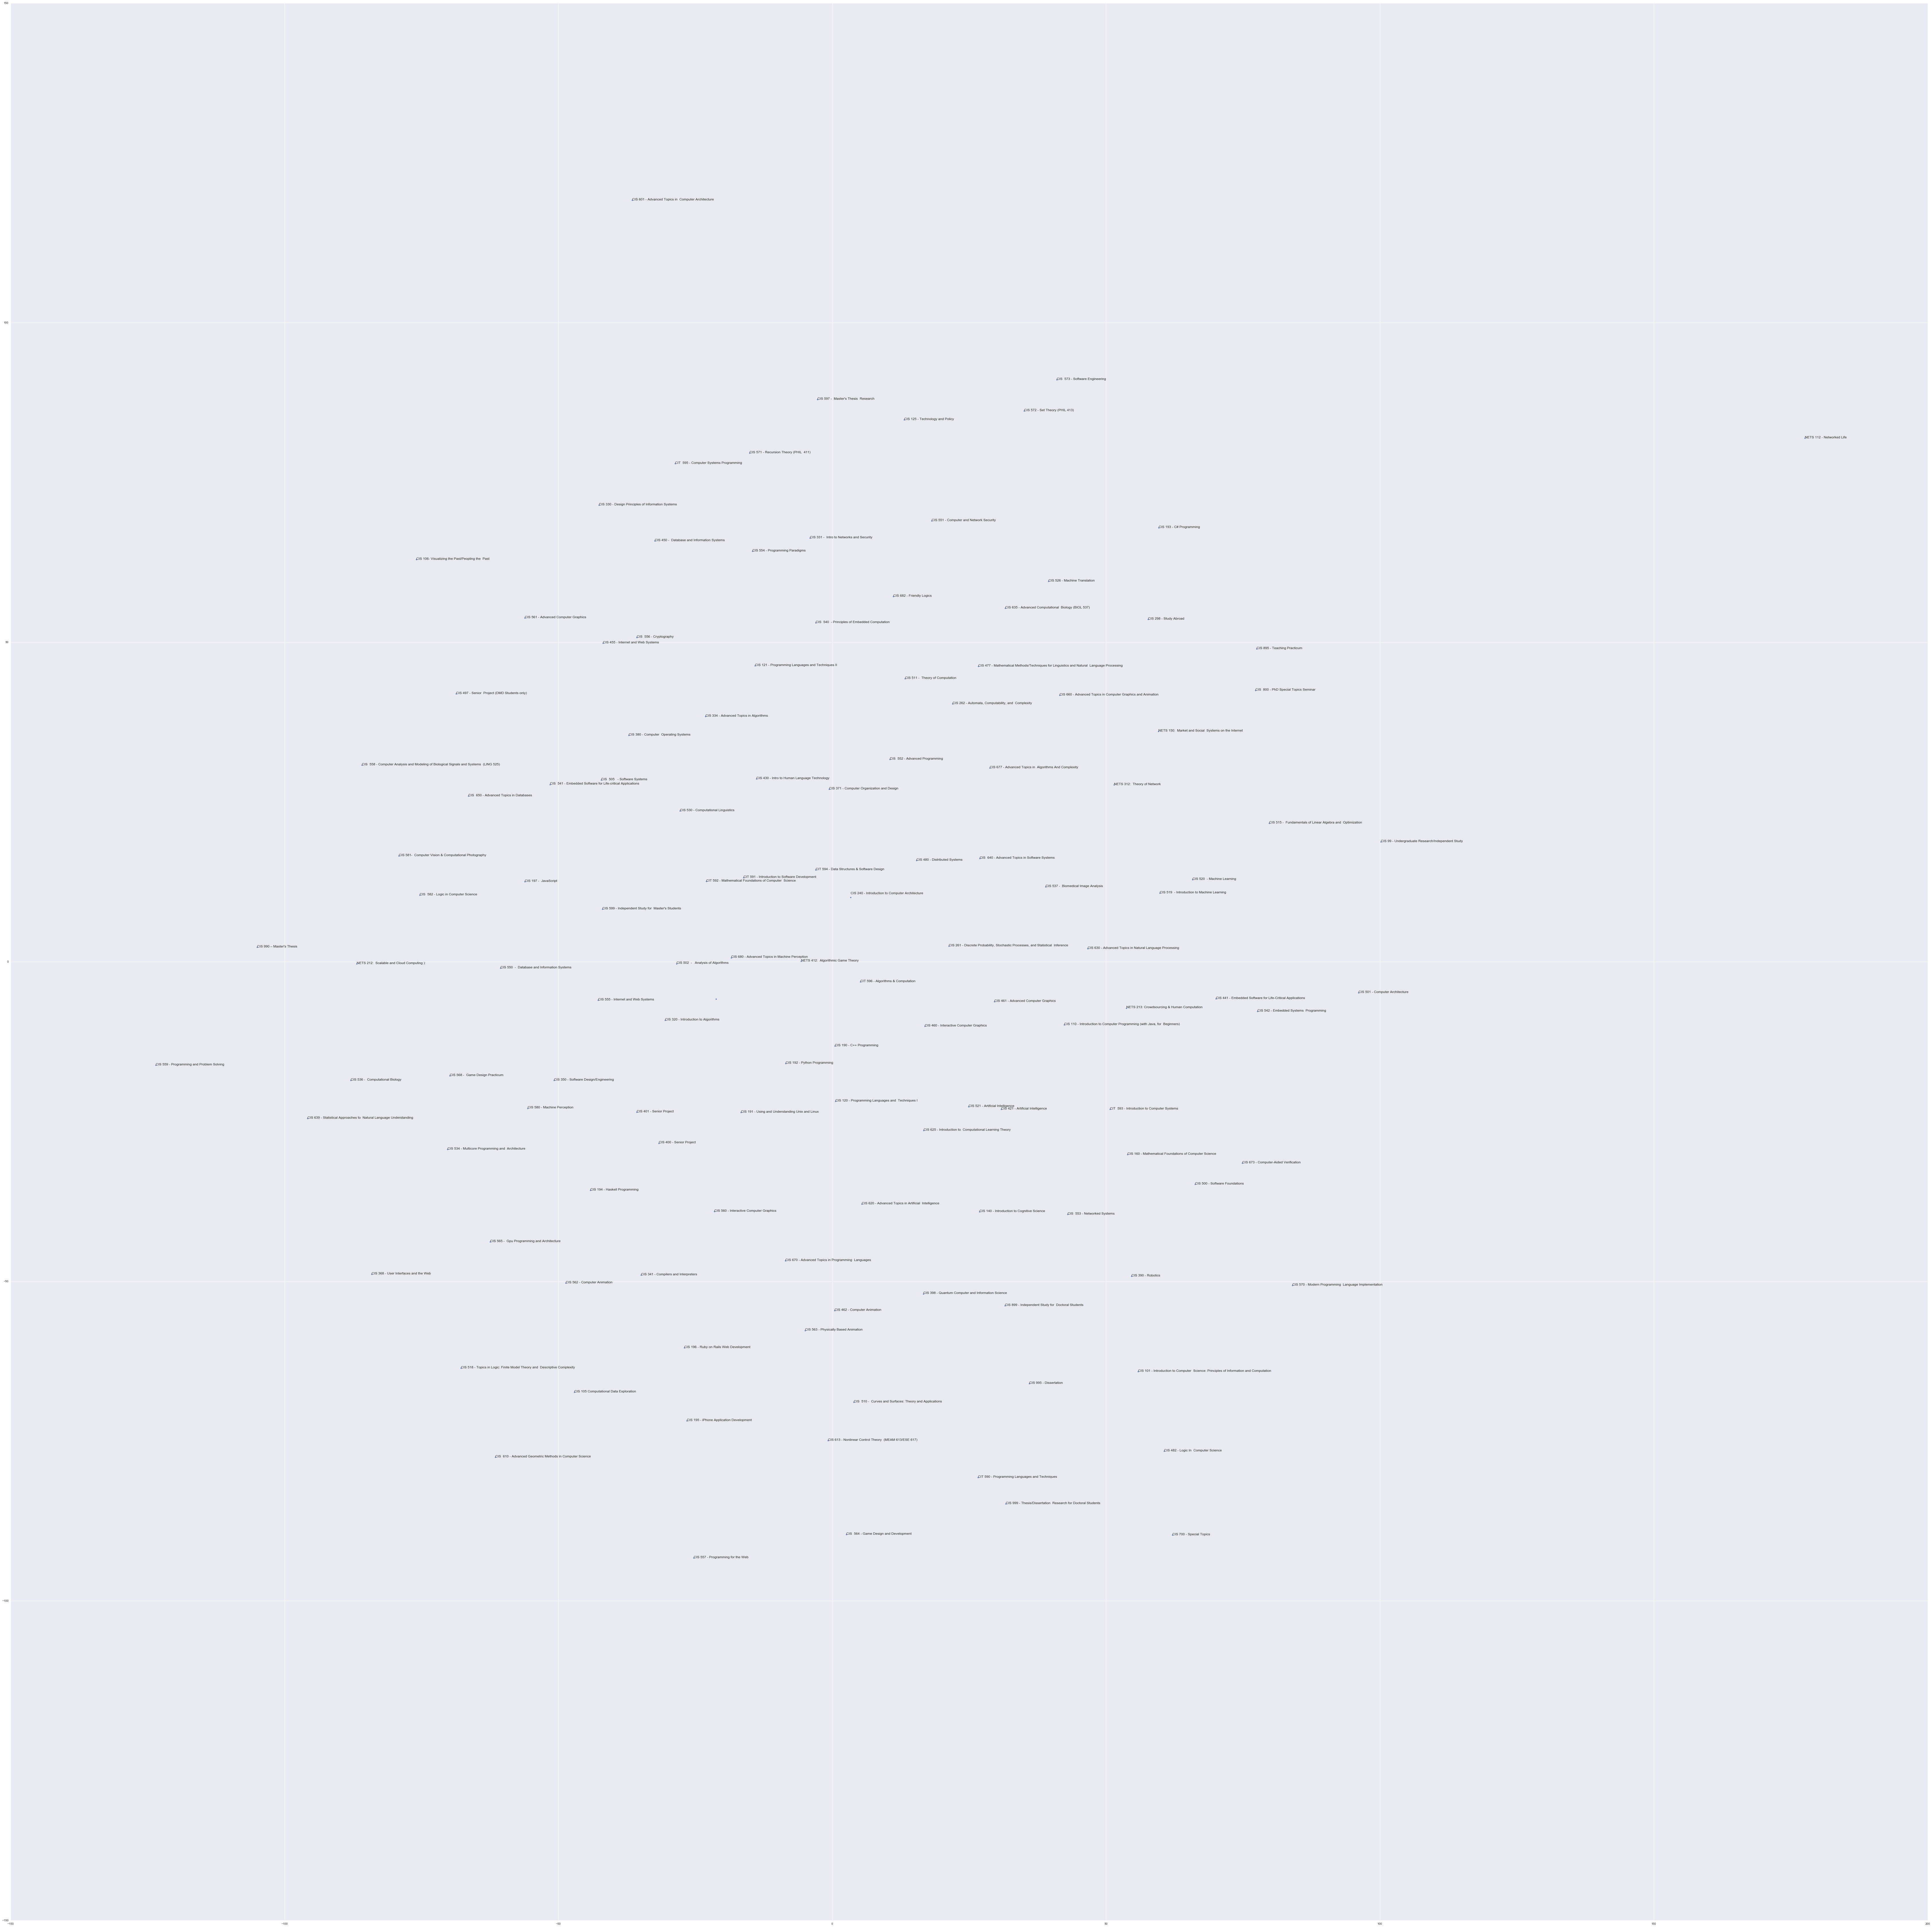

In [73]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(120, 120))
sns.regplot(tsne[:, 0], tsne[:, 1], fit_reg=False)
for label, x, y in zip(course_names, tsne[:, 0], tsne[:, 1]):
    plt.annotate(label, xy = (x, y))
plt.show()